In [1]:
import importlib
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
from numpy import nan
from constants import *
import sys
import warnings
import math
import os
import cftime
from glob import glob
from timeit import default_timer as timer # try to measure time
from CASutils import readdata_utils as read
from CASutils import calendar_utils as cal

In [2]:
# define functions
def read_cmip6(filepath,datestart,dateend):
    #open netcdf dataset
    dat = xr.open_mfdataset(filepath, coords="minimal", join="override", decode_times = True, use_cftime=True)  
    #convert calendar to standard, setting missing values as NaNs
    dat = dat.convert_calendar("standard", use_cftime=True, align_on="date",missing=np.nan)
    #interpolate the dataset using cftim_range
    dateidx = xr.cftime_range(datestart,dateend,freq='D',calendar="standard") 
    dat = dat.interp(time=dateidx,method="nearest") 
    #take slice
    dat = dat.sel(time=slice(datestart, dateend))
    dat = xr.decode_cf(dat, use_cftime = True) 
    return dat

#def read_field(filepath, datestart, dateend,latmin,latmax,plev):
#    """Read in a time slice from datestart to dateend and calculate the zonal mean.
#    Try using datetime64 and if that doesn't work decode times manually.
#    Args:
#        filepath (string) = path to files e.g., "/path/to/files/*.nc"
#        datestart (string) = start date for time slice
#        dateend (string) = end date for time slice
#    """
#
#    try:
#        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
#                 decode_times=True, use_cftime=True).\
#                 sel(time=slice(datestart, dateend),lat=slice(latmin,latmax),plev=plev)
#
#    except:
#                
#        print("Something's wierd about the time axis, decoding manually")
#        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
#                   decode_times=False)
#
#        dat=xr.decode_cf(dat, use_cftime=True)
#        dat=dat.sel(time=slice(datestart, dateend),lat=slice(latmin,latmax),plev=plev)
#        datetimeindex=dat.indexes['time'].to_datetimeindex()
#        dat['time'] = datetimeindex
#
#    return dat

def read_field(filepath, datestart, dateend,latmin,latmax,plev):
    """Read in a time slice from datestart to dateend and calculate the zonal mean.
    Try using datetime64 and if that doesn't work decode times manually.
    Args:
        filepath (string) = path to files e.g., "/path/to/files/*.nc"
        datestart (string) = start date for time slice
        dateend (string) = end date for time slice
    """

    try:
        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
                 decode_times=True, use_cftime=True)

    except:
                
        print("Something's wierd about the time axis, decoding manually")
        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
                   decode_times=False)

        dat=xr.decode_cf(dat, use_cftime=True)
        datetimeindex=dat.indexes['time'].to_datetimeindex()
        dat['time'] = datetimeindex
        
    dat=dat.sel(time=slice(datestart, dateend),lat=slice(latmin,latmax),plev=plev)
    return dat

def get_lat_lon_res(ds):
    '''Function to obtain the average lat and lon gridspacing from a dataset of a non regular model grid. '''
    lat = ds.coords['lat']
    lon = ds.coords['lon']
    difflat = lat - lat.shift(lat=1)
    latres = difflat.mean().to_numpy()
    difflon = lon - lon.shift(lon=1)
    lonres = difflon.mean().to_numpy()
    return latres, lonres

def def_domain(ncdf,min_lat,max_lat,min_lon,max_lon):
    LatIndexer, LonIndexer = 'lat', 'lon'
    ncdf = ncdf.loc[{LatIndexer: slice(min_lat, max_lat),
                      LonIndexer: slice(min_lon, max_lon)}]
    return ncdf

def norm_lon(ncdf):
    ncdf.coords['lon'] = (ncdf.coords['lon'] + 180) % 360 - 180
    return ncdf.sortby(ncdf.lon)

def get_ONDJFM_day(ncdf, months=[1,2,3,10,11,12],timedim="day"):
    return ncdf.isel({timedim:ncdf[timedim].dt.month.isin(months)})

In [3]:
os.chdir('/home/lseverino/MT/scripts')
importlib.reload(read)
importlib.reload(cal)
warnings.filterwarnings('ignore')


In [11]:
## constants
#paths
histpath="/net/atmos/data/cmip6/historical/"
ssp119path="/net/atmos/data/cmip6/ssp119/"
ssp126path="/net/atmos/data/cmip6/ssp126/"
ssp245path="/net/atmos/data/cmip6/ssp245/"
ssp370path="/net/atmos/data/cmip6/ssp370/"
ssp585path="/net/atmos/data/cmip6/ssp585/"

scenlist = ["historical","ssp126","ssp245","ssp370","ssp585"]
pathlist = [histpath,ssp126path,ssp245path,ssp370path,ssp585path]
pathdic = {"historical":histpath,"ssp126":ssp126path,"ssp245":ssp245path,"ssp370":ssp370path,"ssp585":ssp585path}

#cmip6models=pd.read_csv('../cmip6csvinfo/cmip6csvinfo_timeseries_ssp585_luca_daily.csv')

In [12]:
## check available data
#select data
tres = "day/"
var="sfcWindmax"

# get directories and member names
#nmems_hist = dict()
##nmems_ssp119 = dict()
#nmems_ssp126 = dict()
#nmems_ssp245 = dict()
#nmems_ssp370 = dict()
#nmems_ssp585 = dict()
dicscen = dict()
models_df = pd.DataFrame(columns=scenlist)
for ind,scen in enumerate(scenlist):
    path = pathlist[ind]
    dicscen[scen] = dict()
    for subdir in os.scandir(path+tres+var):
        #models_rcp85[subdir.name]=[]
        dicscen[scen][subdir.name] = [len(os.listdir(subdir))]
        dicscen[scen][subdir.name].append(os.listdir(subdir))
        models_df.loc[subdir.name,scenlist[ind]] = len(os.listdir(subdir))
models_df.loc["total",:] = models_df.count(axis=0)
nmems_hist = dicscen['historical']
nmems_ssp585 = dicscen['ssp585']

In [13]:
models_df

,historical,ssp126,ssp245,ssp370,ssp585
AWI-CM-1-1-MR,5,1,1,5,1
AWI-ESM-1-1-LR,1,NaN,NaN,NaN,NaN
BCC-CSM2-MR,1,1,1,1,1
BCC-ESM1,1,NaN,NaN,3,NaN
CanESM5,50,50,50,50,50
CNRM-CM6-1,30,6,6,6,6
CNRM-ESM2-1,10,5,10,3,5
CNRM-CM6-1-HR,1,1,1,1,1
EC-Earth3-Veg,9,7,8,6,8
EC-Earth3,23,3,43,3,3


In [14]:
#select all models with minimum 3 members for the 5 scenarios
mods_3mem_allscen = models_df.where(models_df>=3).dropna(how='any').iloc[:-1,:]
mods_1mem_allscen = models_df.where(models_df>=1).dropna(how='any').iloc[:-1,:]
mods_1mem_hist_ssp585= models_df[["historical","ssp585"]].where(models_df[["historical","ssp585"]]>=1).dropna(how='any').iloc[:-1,:]


In [15]:
#create table with model considered for the thesis
mods_1mem_allscen[(mods_1mem_allscen>3)] =3
modlist_not_allscen = mods_1mem_allscen[(mods_1mem_allscen['ssp126'] < 3 ) | (mods_1mem_allscen['ssp245'] < 3 ) | (mods_1mem_allscen['ssp370'] < 3 )].index.tolist()
mods_1mem_allscen.loc[modlist_not_allscen,['ssp126','ssp245','ssp370']] = np.nan


In [16]:
# turn dicts into pd DataFrames because more convenient
nmems_hist_df = pd.DataFrame(nmems_hist, index=["hist","memnames"])
nmems_ssp585_df = pd.DataFrame(nmems_ssp585, index=["ssp585","memnames"])

In [17]:
#get member names (previously used)
memname_df = pd.read_csv('/home/lseverino/MT/metadata/memnames_ssp585_hist_SWM.csv',header=[0,1],index_col=0)

In [18]:
memname_df

scen               historical                           ssp585             \
imem                        0          1          2          0          1   
CanESM5             r10i1p1f1  r10i1p2f1  r11i1p1f1  r10i1p1f1  r10i1p2f1   
CNRM-CM6-1          r10i1p1f2   r1i1p1f2   r2i1p1f2   r1i1p1f2   r2i1p1f2   
CNRM-ESM2-1          r1i1p1f2   r2i1p1f2   r3i1p1f2   r1i1p1f2   r4i1p1f2   
EC-Earth3-Veg        r1i1p1f1   r4i1p1f1   r2i1p1f1   r2i1p1f1   r3i1p1f1   
EC-Earth3-Veg-LR     r1i1p1f1   r2i1p1f1   r3i1p1f1   r1i1p1f1   r2i1p1f1   
IPSL-CM6A-LR        r10i1p1f1  r11i1p1f1  r12i1p1f1  r14i1p1f1   r4i1p1f1   
MIROC-ES2L        r1i1000p1f2  r13i1p1f2  r11i1p1f2   r1i1p1f2  r10i1p1f2   
UKESM1-0-LL          r1i1p1f2   r2i1p1f2   r3i1p1f2   r1i1p1f2   r4i1p1f2   
MRI-ESM2-0           r1i1p1f1   r2i1p1f1   r3i1p1f1   r1i1p1f1   r1i2p1f1   
FGOALS-g3            r1i1p1f1   r3i1p1f1   r5i1p1f1   r1i1p1f1   r3i1p1f1   
ACCESS-ESM1-5        r1i1p1f1   r3i1p1f1   r2i1p1f1   r1i1p1f1   r3i1p1f1   
MIROC6              r10i1p1f1   r1i1p1f1   r2i1p1f1   r1i1p1f1   r2i1p1f1   
MPI-ESM1-2-LR       r10i1p1f1   r9i1p1f1   r5i1p1f1   r1i1p1f1  r10i1p1f1   
KACE-1-0-G           r2i1p1f1   r1i1p1f1   r3i1p1f1   r1i1p1f1   r2i1p1f1   
AWI-CM-1-1-MR        r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
BCC-CSM2-MR          r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
CNRM-CM6-1-HR        r1i1p1f2        NaN        NaN   r1i1p1f2        NaN   
EC-Earth3-CC         r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
HadGEM3-GC31-LL      r1i1p1f3   r2i1p1f3   r3i1p1f3   r1i1p1f3   r3i1p1f3   
GISS-E2-1-G          r1i1p1f1        NaN        NaN   r1i1p1f2        NaN   
GFDL-CM4             r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
CMCC-CM2-SR5         r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
CMCC-ESM2            r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
HadGEM3-GC31-MM      r1i1p1f3   r2i1p1f3   r4i1p1f3   r1i1p1f3   r3i1p1f3   
NESM3                r1i1p1f1   r2i1p1f1        NaN   r2i1p1f1   r1i1p1f1   
MPI-ESM1-2-HR       r10i1p1f1   r4i1p1f1        NaN   r1i1p1f1   r2i1p1f1   
INM-CM4-8            r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
INM-CM5-0            r5i1p1f1        NaN        NaN   r1i1p1f1        NaN   
ACCESS-CM2           r4i1p1f1   r5i1p1f1        NaN   r4i1p1f1   r5i1p1f1   

scen                        
imem                     2  
CanESM5           r1i1p1f1  
CNRM-CM6-1        r3i1p1f2  
CNRM-ESM2-1       r5i1p1f2  
EC-Earth3-Veg     r1i1p1f1  
EC-Earth3-Veg-LR  r3i1p1f1  
IPSL-CM6A-LR      r2i1p1f1  
MIROC-ES2L        r2i1p1f2  
UKESM1-0-LL       r2i1p1f2  
MRI-ESM2-0        r2i1p1f1  
FGOALS-g3         r4i1p1f1  
ACCESS-ESM1-5     r2i1p1f1  
MIROC6            r3i1p1f1  
MPI-ESM1-2-LR     r3i1p1f1  
KACE-1-0-G        r3i1p1f1  
AWI-CM-1-1-MR          NaN  
BCC-CSM2-MR            NaN  
CNRM-CM6-1-HR          NaN  
EC-Earth3-CC           NaN  
HadGEM3-GC31-LL   r2i1p1f3  
GISS-E2-1-G            NaN  
GFDL-CM4               NaN  
CMCC-CM2-SR5           NaN  
CMCC-ESM2              NaN  
HadGEM3-GC31-MM   r2i1p1f3  
NESM3                  NaN  
MPI-ESM1-2-HR          NaN  
INM-CM4-8              NaN  
INM-CM5-0              NaN  
ACCESS-CM2             NaN

##initiate df to store member names
#allscens
colidx = ['historical','ssp126','ssp245','ssp370','ssp585']
nmems=3
iterrows = [modlist_allscen+modlist_ssp585,range(nmems)]
rowidx= pd.MultiIndex.from_product(iterrows,names=["model","member"])
memnames_v2 = pd.DataFrame(columns=colidx,index=rowidx)
memnames_v2.to_csv('/home/lseverino/MT/metadata/memnames_v2_SWM.csv')

In [19]:
memname_df_v2 = pd.read_csv('/home/lseverino/MT/metadata/memnames_v2_SWM.csv',header=[0],index_col=[0,1])

In [13]:
memname_df_v2

historical    ssp126    ssp245    ssp370    ssp585
model      member                                                   
CanESM5    0        r1i1p1f1  r1i1p1f1  r1i1p1f1  r1i1p1f1  r1i1p1f1
           1        r2i1p1f1  r2i1p1f1  r2i1p1f1  r2i1p1f1  r2i1p1f1
           2        r3i1p1f1  r3i1p1f1  r3i1p1f1  r3i1p1f1  r3i1p1f1
CNRM-CM6-1 0        r1i1p1f2  r1i1p1f2  r1i1p1f2  r1i1p1f2  r1i1p1f2
           1        r2i1p1f2  r2i1p1f2  r2i1p1f2  r2i1p1f2  r2i1p1f2
...                      ...       ...       ...       ...       ...
INM-CM5-0  1             NaN       NaN       NaN       NaN       NaN
           2             NaN       NaN       NaN       NaN       NaN
ACCESS-CM2 0        r4i1p1f1       NaN       NaN       NaN  r4i1p1f1
           1        r5i1p1f1       NaN       NaN       NaN  r5i1p1f1
           2             NaN       NaN       NaN       NaN       NaN

[87 rows x 5 columns]

## Select data

In [42]:
## select variables
#selvar = 'sfcWindmax'
var = 'sfcWindmax'
tres = 'day'

#spatial domain
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

#members
nmems_max = 3 #max number of members to consider

#preprocessing and regridding
#gst_fact = 1.67
#qt = 0.98
regrid = False #regrid to a certain resolution
norm = False #normalize grid to a regular grid

#select scenarios
selscen = ['ssp585']
#selscen = ['historical','ssp126','ssp245','ssp370','ssp585']

## naming to save data
#name base (meteo) variable
metvar = [cmip6vars[var]]    
spaceres = ["br"] #original resolution not regridded
timeres = [tres]
domain = ["EU"]
season = ["winE"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
basenamemet = sep.join(lst_bn)
pathout="../cmip6/"+var+'/'

In [43]:
## select dates
#consider ONJDFM: start in D, finishes in M, adjust to have same number of days in both periods
ybegp = 1980 ; monbegp = 10 ; yendp = 2010 ; monendp = 3 ; daybegp = 1 ; dayendp = 30# dates for Past period, only takes 30th 
#ybegf = 2070 ; monbegf = 1 ; yendf = 2099 ; monendf = 12 ; daybegf = 1 ; dayendf = 31# dates for Future period
ybegf = 2070 ; monbegf = 10 ; yendf = 2100 ; monendf = 3 ; daybegf = 1 ; dayendf = 30# otherwise dont have the same length

# total number of months (used for checking)
nmonthsp = (yendp-ybegp-1)*12 + (12-monbegp+1) + monendp
nmonthsf = (yendf-ybegf-1)*12 + (12-monbegf+1) + monendf

# set up date names
dateformat ='%Y-%m-%d'

datebegp=str(ybegp)+"-"+str(monbegp).zfill(2)+"-"+str(daybegp).zfill(2)
dateendp=str(yendp)+"-"+str(monendp).zfill(2)+"-"+str(dayendp).zfill(2)
datebegf=str(ybegf)+"-"+str(monbegf).zfill(2)+"-"+str(daybegf).zfill(2)
dateendf=str(yendf)+"-"+str(monendf).zfill(2)+"-"+str(dayendf).zfill(2)

#set up daterange indexes
#daysidp = pd.date_range(datebegp,dateendp,freq='D')
#daysidf = pd.date_range(datebegf,dateendf,freq='D')

daysidp = xr.cftime_range(datebegp,dateendp,freq='D',calendar='standard')
daysidf = xr.cftime_range(datebegf,dateendf,freq='D',calendar='standard')

#nb of days
ndaysp = len(daysidp)
ndaysf = len(daysidf)

dayrangep = np.arange(1,ndaysp+1,1)
dayrangef = np.arange(1,ndaysf+1,1)

In [44]:
## select models
#try with models that have at least 3 members per scenario
modlist_3mem = mods_3mem_allscen.index.tolist()
modlist_1mem_sel = mods_1mem_hist_ssp585.drop(index=mods_3mem_allscen.index)
#modlist_1mem_sel = modlist_1mem_sel.drop(index=['HadGEM3-GC31-MM','HadGEM3-GC31-LL'])
model_dl = []
modlist = modlist_allscen
modlist = [model for model in modlist if model not in model_dl]
modlist = ['MPI-ESM1-2-HR']
for model in modlist:
    print("Members, historical: "+str(nmems_hist[model][0])+"\nMembers, rcp85: ",str(dicscen['ssp585'][model][0]))
models = pd.Series(modlist)

Members, historical: 10
Members, rcp85:  2


In [23]:
modlist_1mem_sel

,historical,ssp585
AWI-CM-1-1-MR,5,1
BCC-CSM2-MR,1,1
CNRM-CM6-1-HR,1,1
EC-Earth3-CC,3,1
HadGEM3-GC31-LL,5,4
GISS-E2-1-G,2,1
GFDL-CM4,1,1
CMCC-CM2-SR5,11,1
CMCC-ESM2,1,1
HadGEM3-GC31-MM,4,4


In [51]:
##open load and process ncdf

nmods = len(models)
modout=np.arange(0,nmods)
memname_df_v2 = pd.read_csv('/home/lseverino/MT/metadata/memnames_v2_SWM.csv',header=[0],index_col=[0,1])

for index, modname in models.iteritems():
    start_time = timer()
    #select nb of members to consider
    if modname in modlist_allscen:
        nmems = nmems_max #take nmems_max members at most
    else:
        nmems_av = models_df.loc[modname,['historical','ssp585']].min() #only consider members when available for both hist and ssp585
        nmems = min(nmems_av,nmems_max) #take all members if below nmems_max, and nmems_max otherwise
        
    #nmemsmin = modlist_1mem_sel.loc[modname].min()
    #nmems = min((nmemsmin,nmem_max))
    #nmems= 1
    #memlistp = nmems_hist[modname][1]
    #get model resolution
    
    for scen in selscen:
            #select path
            scenpath = pathdic[scen]
            #get nb of available members and their names
            memdic = dicscen[scen][modname]
            memnb = memdic[0]
            memnames = memdic[1]
            #memnames_mod = memname_df.loc[modname,scen]
            #nmems = len(memnames_mod.dropna())
            #nmems = min(memnb,nmems_max) #take all members if below nmems_max, and nmems_max otherwise
            memout=np.arange(0,nmems) 
            mem_av = 0
            
            for imem in range(nmems):
                
                #try with i=1, p=1 and f=1
                rlist = [1,2,3] #list of available real
                ri = rlist[imem]
                memname = "r"+str(ri)+"i1p1f1"
                if memname in memnames:
                    print("Processing "+scen+" for "+modname+" "+memname+"...")
                    #count member actually available
                    mem_av = mem_av + 1
                    memname_df_v2.loc[(modname,imem),scen] = memname
                else:
                    print('Member: ' + memname + 'not available for model: '+modname+' and scen '+ scen)
                    continue

                #memname = str(memlist[imem])
                #memname = memname_df.loc[modname,(scen,str(imem))]
                scendir = glob(scenpath+tres+"/"+var+"/"+modname+"/"+memname+"/*/")
                scendir = scendir[0]
                #try:
                #    
                #except:
                #    continue
                
                
                # read in zonal mean u
                if scen == 'historical':
                    datebeg = datebegp
                    dateend = dateendp
                else: 
                    datebeg = datebegf
                    dateend = dateendf
                    
                u=read.read_sfc(scendir+"*.nc", datebeg,dateend)
                utemp = u[var]
                
                # check the size of the time dim
                daysid = utemp.time
                ndays = len(daysid)
                if (u.time.size !=  ndays):
                    print("something's wrong, ndaysf="+str(ndays)+" but u has size "+str(u.time.size))
                
                #get grid spec (only if first member and keep same specs for following members)
                if imem==0:                    
                    if norm: #normalize grid to a regular grid
                        #get lat, lon, latres and lonres
                        lat = utemp.lat
                        lon = utemp.lon
                        minlato=lat[0].to_numpy()
                        maxlato=lat[-1].to_numpy()
                        minlono=lon[0].to_numpy()
                        maxlono=lon[-1].to_numpy()
                        latres, lonres = get_lat_lon_res(utemp)
        
                        if regrid:
                            latres = latrg
                            lonres = lonrg
                        else:
                            latres = latres.round(4)
                            lonres = lonres.round(4)
                            
                        latout = np.arange(minlato,maxlato+latres,latres)
                        lonout = np.arange(minlono,maxlono+lonres,lonres)
                        
                    else: #use source resolution
                        latout = utemp.lat
                        lonout = utemp.lon
                    
                    #initialize empty array
                    uzmem = xr.DataArray(np.zeros([ ndays, latout.size, lonout.size, nmems]), 
                                          coords=[daysid, latout, lonout, memout],dims=['time','lat','lon','member'], name=scen)
                
                #read data
                if norm: #interpolation if regridding/regularization
                    uread = utemp.interp(lat=latout,lon=lonout, method='linear',kwargs={"fill_value": None})
        
                else: #slicing otherwise
                    uread = utemp
                    #uread = utemp.sel(lat=slice(minlato,maxlato),lon=slice(minlono,maxlono))
                
                #write into da
                uread = uread.rename({'time': 'time_o'}) #rename to avoid conflicts between indexing and indexed objects
                
                try:
                    uzmem.loc[dict(member=imem)]=uread
                except IndexError:#if index error, interpolate on the grid of the target data array
                    lati = uzmem.lat
                    loni = uzmem.lon
                    uread = uread.interp(lat=latout,lon=lonout, method='linear',kwargs={"fill_value": None})
                    uzmem.loc[dict(member=imem)]=uread
                
                #del objects to speed up things?
                #del u
                #del utemp
                #del uread
                
            #skip rest if no members were found
            if mem_av==0:
                continue
            
            
            ## processings
            # normalize longitude
            uzmemn = norm_lon(uzmem)
            
            #interpolate nans at 0deg longitude
            if np.any(np.isnan(uzmemn.dropna(dim="time",how='all'))):
                print('interpolating nans...')
                uzmemn = uzmemn.interpolate_na(dim="lon", method="linear")
            
            #try interpolating nans 
            #uzmemn = uzmemn.interpolate_na(dim="lon", method="linear")
            #or
            #min_lat,max_lat = 35,73
            #min_lon,max_lon = -35,35
            
            Usfc_EU = def_domain(uzmemn,min_lat,max_lat,min_lon,max_lon)
            
            #set time indexes
            dayrange = np.arange(1,ndays+1,1)
            Usfc_EU = Usfc_EU.assign_coords({"day":("time",dayrange)})
            
            #select winter months
            Usfc_EU_win = get_ONDJFM_day(Usfc_EU,timedim="time")
            
            #try to remove abonormal values
            #Usfc_EU_win = Usfc_EU_win.where(Usfc_EU_win.values >= 0) # values below 0 are discarded
            #Usfc_EU_win = Usfc_EU_win.where(Usfc_EU_win.values < 100) # values above 100 are discarded
            
        
            #swap dims to assemble files in the same dataset
            
            
            Usfc_EU_win = Usfc_EU_win.swap_dims({"time":"day"})
            
            #set time index as a data variable
            Usfc_EU_win = Usfc_EU_win.reset_coords()
            
            if scen == 'historical':
                timename = 'timep'
            else:
                timename = 'timef'
            Usfc_EU_win = Usfc_EU_win.rename(time=timename)
            
            #save to netcdf
            
            try:# see if file exist and merge to it
                #datain = xr.open_dataset(pathout+modname+'_'+basenamemet+".nc")
                #merged = xr.merge([datain,Usfc_EU_win])
                #merged.to_netcdf(path=pathout+modname+'_'+basenamemet+".nc",mode="a",engine="scipy")
                Usfc_EU_win.to_netcdf(path=pathout+modname+'_'+basenamemet+".nc",mode="a")
            except: #otherwise directly create the file
                #Usfc_EU_win.to_netcdf(path=pathout+modname+'_'+basenamemet+"_allscens"+".nc",engine="scipy")
                Usfc_EU_win.to_netcdf(path=pathout+modname+'_'+basenamemet+".nc")
                          
        
            time_delta_fut = timer() - start_time
            print(time_delta_fut)
            
    #append model to list of downloaded models
    #model_dl.append(modname)
#memname_df_v2.to_csv('/home/lseverino/MT/metadata/memnames_v2_SWM.csv')

Processing ssp585 for MPI-ESM1-2-HR r1i1p1f1...
Processing ssp585 for MPI-ESM1-2-HR r2i1p1f1...
100.87749824400089


In [62]:
ncdf2 = xr.open_mfdataset(pathout+"NESM3_SWM_br_day_EU_winE.nc")

(array([1.259090e+06, 2.738732e+06, 2.119536e+06, 1.392820e+06,
        7.616870e+05, 2.973330e+05, 7.403800e+04, 1.319000e+04,
        1.593000e+03, 1.250000e+02]),
 array([ 0.22806664,  3.40388325,  6.57969986,  9.75551647, 12.93133309,
        16.1071497 , 19.28296631, 22.45878292, 25.63459953, 28.81041615,
        31.98623276]),
 <BarContainer object of 10 artists>)

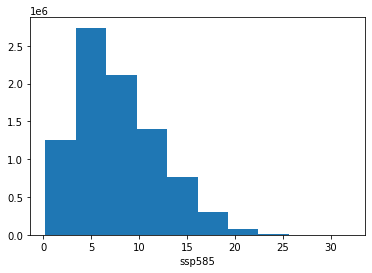

In [65]:
ncdf2.ssp585.plot()